# Segmentez des clients d'un site e-commerce
## Dataset Cleaning

In [76]:
%load_ext pycodestyle_magic
%pycodestyle_on

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


## Imports

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from datetime import datetime, timedelta
import time

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [78]:
orders = pd.read_csv('archive/olist_orders_dataset.csv')

orders_payments = pd.read_csv('archive/olist_order_payments_dataset.csv')

orders_items = pd.read_csv('archive/olist_order_items_dataset.csv')

customers = pd.read_csv('archive/olist_customers_dataset.csv')

reviews = pd.read_csv('archive/olist_order_reviews_dataset.csv')

## Exploration

In [79]:
orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00


In [80]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [81]:
orders.duplicated(subset=['order_id']).sum()

0

In [82]:
orders_payments.head(2)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39


In [83]:
orders_payments.isna().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [84]:
orders_payments.duplicated(subset=['order_id']).sum()

4446

In [85]:
orders_items.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


In [86]:
orders_items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [87]:
orders_items.duplicated(subset=['order_id', 'order_item_id']).sum()

0

In [88]:
customers.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP


In [89]:
customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [90]:
customers.duplicated(subset=['customer_unique_id']).sum()

3345

In [91]:
reviews.head(2)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13


In [92]:
reviews.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [93]:
reviews.duplicated(subset=['order_id']).sum()

551

## Start of Cleaning 

Goal is to merge data into a unique RFM dataframe (with some more data, like delivery time, numbers of items or review score)

In [94]:
delivered_mask = (orders['order_status'] == 'delivered')
orders.loc[delivered_mask].isna().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

In [95]:
# Fill missing delivery dates by estimated dates
mask = (delivered_mask & orders['order_delivered_customer_date'].isna())

orders['order_delivered_customer_date'].loc[mask] =\
    orders['order_estimated_delivery_date'].loc[mask]

In [137]:
# Sum the payment values for a unique order_id
# Mean payment installments values for a unique order_id
payments = orders_payments.groupby('order_id').agg({
    'payment_value': 'sum',
    'payment_installments': 'mean'
}).reset_index()
payments.isna().sum()

order_id                0
payment_value           0
payment_installments    0
dtype: int64

orders_payments : It is possible to have several payment sequential for one order, and several payment installments for each sequential. That is why we sum the payment values and we mean the installments values.

In [97]:
# Sum the quantity of items for a unique order_id
items = orders_items.groupby('order_id').count().reset_index()
items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [98]:
customers['customer_unique_id'].unique().shape

(96096,)

In [99]:
# Keep customers and orders ids, and order date for all delivered orders
customers_infos = ['customer_id',
                   'customer_unique_id']
orders_infos = ['order_id',
                'customer_id',
                'order_purchase_timestamp',
                'order_delivered_customer_date']
delivered_mask = (orders['order_status'] == 'delivered')

# Merge all needed datas in df_infos
df_infos = customers[customers_infos].merge(
    orders[orders_infos].loc[delivered_mask], on='customer_id')

# Add summed payment values by order id to df_info
df_infos = df_infos.merge(payments[['order_id',
                                    'payment_value',
                                    'payment_installments']], on='order_id')

# Add review score by order id to df_info
df_infos = df_infos.merge(reviews[['order_id', 'review_score']], on='order_id')

# Add items qty by order id to df_info
df_infos = df_infos.merge(items[['order_id', 'order_item_id']], on='order_id')

In [100]:
df_infos.sort_values(by='order_purchase_timestamp', ascending=False)

,customer_id,customer_unique_id,order_id,order_purchase_timestamp,order_delivered_customer_date,payment_value,payment_installments,review_score,order_item_id
65207,898b7fee99c4e42170ab69ba59be0a8b,24ac2b4327e25baf39f2119e4228976a,35a972d7f8436f405b56e36add1a7140,2018-08-29 15:00:37,2018-08-30 16:23:36,93.75,1.0,5,1
48344,496630b6740bcca28fce9ba50d8a26ef,b701bebbdf478f5500348f03aff62121,03ef5dedbe7492bdae72eec50764c43f,2018-08-29 14:52:00,2018-08-30 16:36:59,33.23,1.0,3,1
473,6e353700bc7bcdf6ebc15d6de16d7002,7febafa06d9d8f232a900a2937f04338,168626408cb32af0ffaf76711caae1dc,2018-08-29 14:18:28,2018-08-30 16:52:31,61.29,1.0,5,1
81992,e60df9449653a95af4549bbfcb18a6eb,5c58de6fb80e93396e2f35642666b693,0b223d92c27432930dfe407c6aea3041,2018-08-29 14:18:23,2018-08-30 16:24:55,510.96,8.0,5,2
60510,e450a297a7bc6839ceb0cf1a2377fa02,7a22d14aa3c3599238509ddca4b93b01,52018484704db3661b98ce838612b507,2018-08-29 12:25:59,2018-08-30 22:48:27,73.10,7.0,1,1
...,...,...,...,...,...,...,...,...,...
19269,7812fcebfc5e8065d31e1bb5f0017dae,87776adb449c551e74c13fc34f036105,cd3b8574c82b42fc8129f6d502690c3e,2016-10-03 22:31:31,2016-10-14 16:08:00,40.95,4.0,5,1
54459,b8cf418e97ae795672d326288dfab7a7,8d3a54507421dbd2ce0a1d58046826e0,d207cc272675637bfed0062edffd0818,2016-10-03 22:06:03,2016-10-31 11:07:42,133.46,6.0,1,1
7485,6f989332712d3222b6571b1cf5b835ce,61db744d2f835035a5625b59350c6b63,a41c8759fbe7aab36ea07e038b2d4465,2016-10-03 21:13:36,2016-11-03 10:58:07,53.73,1.0,3,1
53476,7ec40b22510fdbea1b08921dd39e63d8,2f64e403852e6893ae37485d5fcacdaf,be5bc2f0da14d8071e2d45451ad119d9,2016-10-03 16:56:50,2016-10-27 18:19:38,39.09,1.0,4,1


In [101]:
# Convert date  from string to datetime
df_infos['order_purchase_timestamp'] =\
    pd.to_datetime(df_infos['order_purchase_timestamp'])
df_infos['order_delivered_customer_date'] =\
    pd.to_datetime(df_infos['order_delivered_customer_date'])

# Add delivry time features (delivery date - order date) in days
df_infos['delivery_time'] = (df_infos['order_delivered_customer_date']
                             - df_infos['order_purchase_timestamp']).dt.days

In [102]:
df_infos.isna().sum()

customer_id                      0
customer_unique_id               0
order_id                         0
order_purchase_timestamp         0
order_delivered_customer_date    0
payment_value                    0
payment_installments             0
review_score                     0
order_item_id                    0
delivery_time                    0
dtype: int64

In [103]:
df_infos.head()

,customer_id,customer_unique_id,order_id,order_purchase_timestamp,order_delivered_customer_date,payment_value,payment_installments,review_score,order_item_id,delivery_time
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017-05-25 10:35:35,146.87,2.0,4,1,8
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,2018-01-29 12:41:19,335.48,8.0,5,1,16
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,2018-06-14 17:58:51,157.73,7.0,5,1,26
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,2018-03-28 16:04:25,173.30,1.0,5,1,14
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,2018-08-09 20:55:48,252.25,8.0,5,1,11


In [104]:
df_infos.dtypes

customer_id                              object
customer_unique_id                       object
order_id                                 object
order_purchase_timestamp         datetime64[ns]
order_delivered_customer_date    datetime64[ns]
payment_value                           float64
payment_installments                    float64
review_score                              int64
order_item_id                             int64
delivery_time                             int64
dtype: object

In [105]:
df_infos.describe()

,payment_value,payment_installments,review_score,order_item_id,delivery_time
count,96360.000000,96360.000000,96360.000000,96360.000000,96360.000000
mean,159.442953,2.913536,4.155749,1.141656,12.058987
std,217.156621,2.698147,1.284952,0.535311,9.462038
min,9.590000,0.000000,1.000000,1.000000,0.000000
25%,61.800000,1.000000,4.000000,1.000000,6.000000
50%,105.140000,2.000000,5.000000,1.000000,10.000000
75%,176.090000,4.000000,5.000000,1.000000,15.000000
max,13664.080000,24.000000,5.000000,21.000000,208.000000


Text(0.5, 1.0, 'Distribution of order delivered dates')

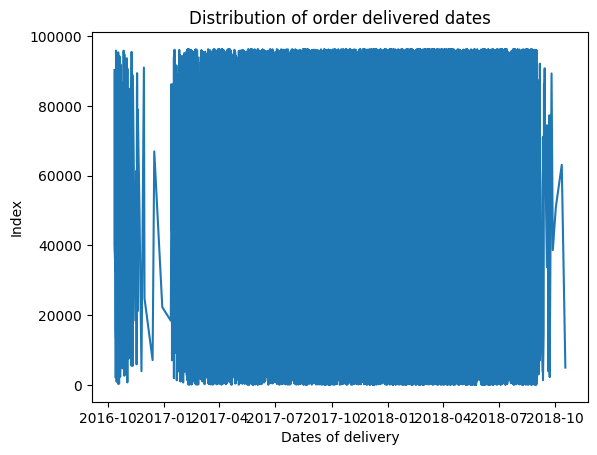

In [106]:
plt.plot(df_infos['order_delivered_customer_date'].sort_values(),
         df_infos['order_delivered_customer_date'].sort_values().index)
plt.ylabel('Index')
plt.xlabel('Dates of delivery')
plt.title('Distribution of order delivered dates')

Text(0.5, 1.0, 'Distribution of order purchase dates')

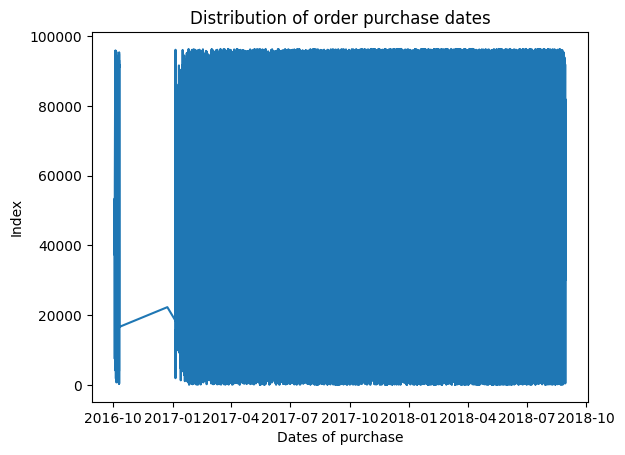

In [107]:
plt.plot(df_infos['order_purchase_timestamp'].sort_values(),
         df_infos['order_purchase_timestamp'].sort_values().index)
plt.ylabel('Index')
plt.xlabel('Dates of purchase')
plt.title('Distribution of order purchase dates')

There is a gap at the end of 2016, which is surprising because of Christmas time.  
We decide to delete outliers "purchase timestamp" in df_infos (before 01-2017)

In [108]:
# mask for outliers date in df_infos
mask_date = (df_infos['order_purchase_timestamp'] < '2017-01')

# Get index to drop and delete the rows in df_infos
dates_to_drop = df_infos.loc[mask_date].index
df_infos.drop(dates_to_drop, inplace=True)
df_infos.shape

(96095, 10)

Text(0.5, 1.0, 'Distribution of order purchase dates')

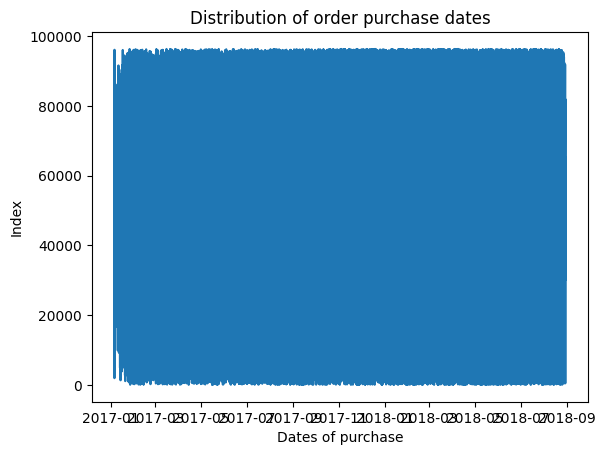

In [109]:
plt.plot(df_infos['order_purchase_timestamp'].sort_values(),
         df_infos['order_purchase_timestamp'].sort_values().index)
plt.ylabel('Index')
plt.xlabel('Dates of purchase')
plt.title('Distribution of order purchase dates')

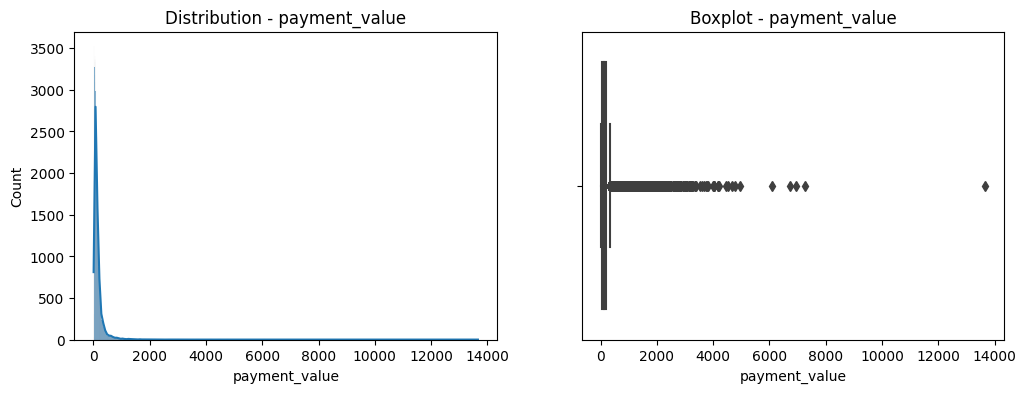

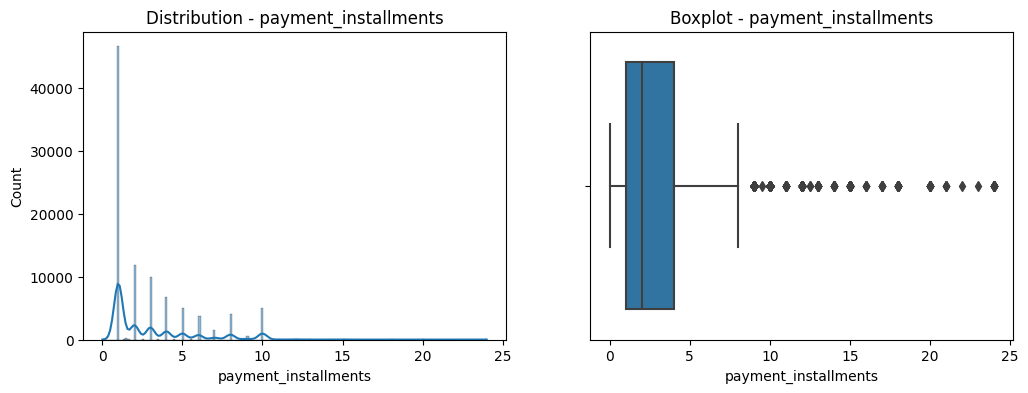

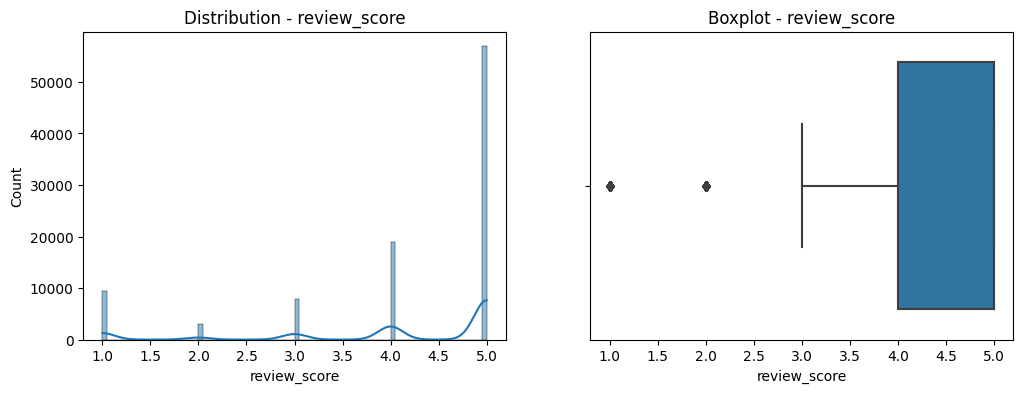

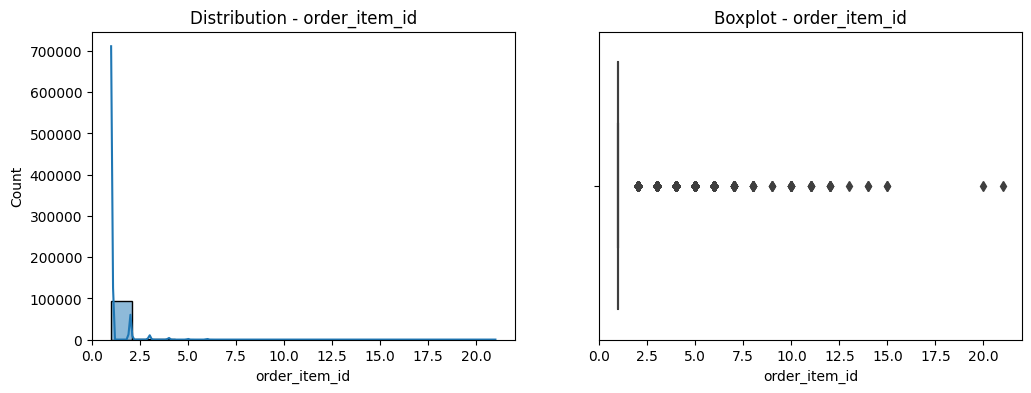

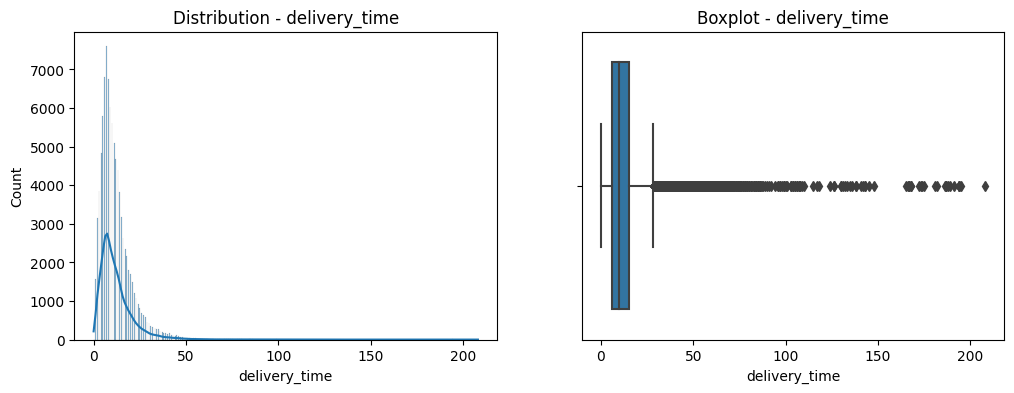

In [110]:
for column in df_infos.select_dtypes(['int64', 'float64']).columns:
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].title.set_text('Distribution - ' + str(column))
    sns.histplot(df_infos, x=column, kde=True, ax=axs[0])

    axs[1].title.set_text('Boxplot - ' + str(column))
    sns.boxplot(df_infos, x=column, ax=axs[1])

    plt.show()

Investigation on the outliers "payment value" in df_infos

In [111]:
# mask for outliers in df_infos
mask_max_payment = (df_infos['payment_value'] > 4000)

# Get ids from mask in df_infos
outliers = df_infos.loc[mask_max_payment, ['customer_id', 'order_id']]
outliers.reset_index(inplace=True, drop=True)

# Get infos from order_items for the stored outliers
items_inf = ['order_id', 'order_item_id', 'product_id', 'price']
mask_product = orders_items['order_id'].isin(outliers['order_id'])

ordout = orders_items[items_inf].loc[mask_product].groupby(['order_id',
                                                            'product_id',
                                                            'price']).max()
ordout.reset_index(inplace=True)

# Merge outlier dataframe with orders_items_outliers dataframe
outliers = outliers.merge(ordout, on='order_id')

# Get the products dataset to see which category are involved
products = pd.read_csv('archive/olist_products_dataset.csv')

# Get infos from product dataframe for the stored outliers
prod_inf = ['product_id', 'product_category_name']
prod_mask = products['product_id'].isin(outliers['product_id'])
prodout = products.loc[prod_mask, prod_inf]

# Merge outliers dataframe with products outliers infos
outliers = outliers.merge(prodout, on='product_id')
outliers

,customer_id,order_id,product_id,price,order_item_id,product_category_name
0,3fd6777bbce08a352fddd04e4a7cc8f6,f5136e38d1a14a4dbd87dff67da82701,1bdf5e6731585cf01aa8169c7028d6ad,6499.00,1,artes
1,35a413c7ca3c69756cb75867d6311c0d,68101694e5c5dc7330c91e1bbc36214f,6cdf8fc1d741c76586d8b6b15e9eef30,4099.99,1,consoles_games
2,1617b1357756262bfa56ab541c47bc16,03caa2c082116e1d31e67e9ae3700499,5769ef0a239114ac3a854af00df129e4,1680.00,8,telefonia_fixa
3,24bbf5fd2f2e1b359ee7de94defc4a15,199af31afc78c699f0dbf71fb178d4d4,c3ed642d592594bb648ff4a04cee2747,4690.00,1,eletroportateis
4,c6e2731c5b391845f6800c97401a43a9,0812eb902a67711a1cb742b3cdaa65ae,489ae2aa008f021502940f251d4cce7f,6735.00,1,utilidades_domesticas
5,df55c14d1476a9a3467f131269c2477f,a96610ab360d42a2e5335a3998b4718a,a6492cc69376c469ab6f61d8f44de961,4799.00,1,eletroportateis
6,eb7a157e8da9c488cd4ddc48711f1097,9de73f3e6157169ad6c32b9f313c7dcb,0eb41884a8773e019708fb8409fd8347,3899.00,1,bebes
7,3d979689f636322c62418b6346b1c6d2,8dbc85d1447242f3b127dda390d56e19,259037a6a41845e455183f89c5035f18,4590.00,1,pcs
8,cc803a2c412833101651d3f90ca7de24,d2f270487125ddc41fd134c4003ad1d7,564a04f027fb97b53ca08464632db860,2200.00,2,relogios_presentes
9,cc803a2c412833101651d3f90ca7de24,d2f270487125ddc41fd134c4003ad1d7,df676834e2a38e1bf267bd85a2dc8e3a,2200.00,1,relogios_presentes


We decide to delete outliers because it is all very specific expenses.

In [112]:
df_infos.shape

(96095, 10)

In [113]:
# mask for outlier in df_infos
mask_max_payment = (df_infos['payment_value'] > 4000)

# Get index to drop and delete the row in df_infos
index_to_drop = df_infos.loc[mask_max_payment].index
df_infos.drop(index_to_drop, inplace=True)
df_infos.shape

(96079, 10)

## Create RFM_matrix 

In [114]:
# Define rfm_matrix dataframe from df_infos, grouping by unique customer id

rfm_matrix = pd.DataFrame()

rfm_matrix['Recency'] = df_infos.groupby('customer_unique_id')[
    'order_purchase_timestamp'].agg('last')
rfm_matrix['Frequency'] = df_infos.groupby(
    'customer_unique_id')['order_id'].count()
rfm_matrix['Monetary value'] = df_infos.groupby(
    'customer_unique_id')['payment_value'].sum()
rfm_matrix['Review score'] = df_infos.groupby(
    'customer_unique_id')['review_score'].mean()
rfm_matrix['Payment installment'] = df_infos.groupby(
    'customer_unique_id')['payment_installments'].mean()
rfm_matrix['Items quantity'] = df_infos.groupby(
    'customer_unique_id')['order_item_id'].mean()
rfm_matrix['Delivery time'] = df_infos.groupby(
    'customer_unique_id')['delivery_time'].mean()

rfm_matrix.reset_index(inplace=True)

In [115]:
# Convert Recency from date string to number of day since max date
rfm_matrix['Recency'] = (rfm_matrix['Recency'].max() -
                         rfm_matrix['Recency']).dt.days

rfm_matrix

,customer_unique_id,Recency,Frequency,Monetary value,Review score,Payment installment,Items quantity,Delivery time
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,5.0,8.0,1.0,6.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,4.0,1.0,1.0,3.0
2,0000f46a3911fa3c0805444483337064,536,1,86.22,3.0,8.0,1.0,25.0
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,4.0,4.0,1.0,20.0
4,0004aac84e0df4da2b147fca70cf8255,287,1,196.89,5.0,6.0,1.0,13.0
...,...,...,...,...,...,...,...,...
92484,fffcf5a5ff07b0908bd4e2dbc735a684,446,1,2067.42,5.0,10.0,2.0,27.0
92485,fffea47cd6d3cc0a88bd621562a9d061,261,1,84.58,4.0,1.0,1.0,30.0
92486,ffff371b4d645b6ecea244b27531430a,567,1,112.46,5.0,1.0,1.0,14.0
92487,ffff5962728ec6157033ef9805bacc48,118,1,133.69,5.0,5.0,1.0,11.0


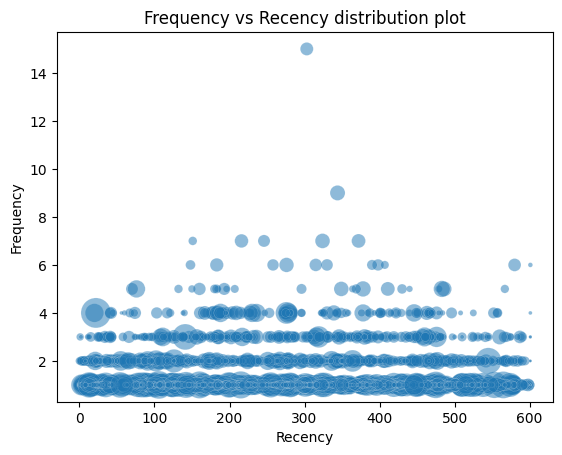

In [116]:
# Point size param based on Monetary value
size = rfm_matrix['Monetary value'] * 0.1

# Creating a scatter plot of RFM dataframe
sns.scatterplot(data=rfm_matrix,
                x='Recency',
                y='Frequency',
                s=size,
                alpha=0.5)

# Adding Labels and title
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Frequency vs Recency distribution plot')

# Showing graph
plt.show()

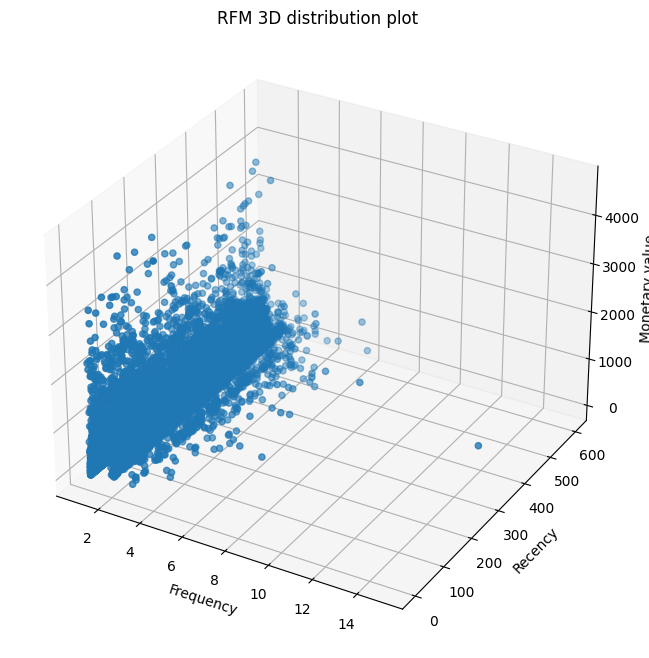

In [117]:
# Creating a 3D scatter plot of RFM dataframe
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = rfm_matrix['Frequency']
y = rfm_matrix['Recency']
z = rfm_matrix['Monetary value']

ax.set_xlabel(rfm_matrix.columns[2])
ax.set_ylabel(rfm_matrix.columns[1])
ax.set_zlabel(rfm_matrix.columns[3])
plt.title('RFM 3D distribution plot')

ax.scatter(x, y, z)

plt.show()

Text(0.5, 1.0, 'Features Correlation matrix')

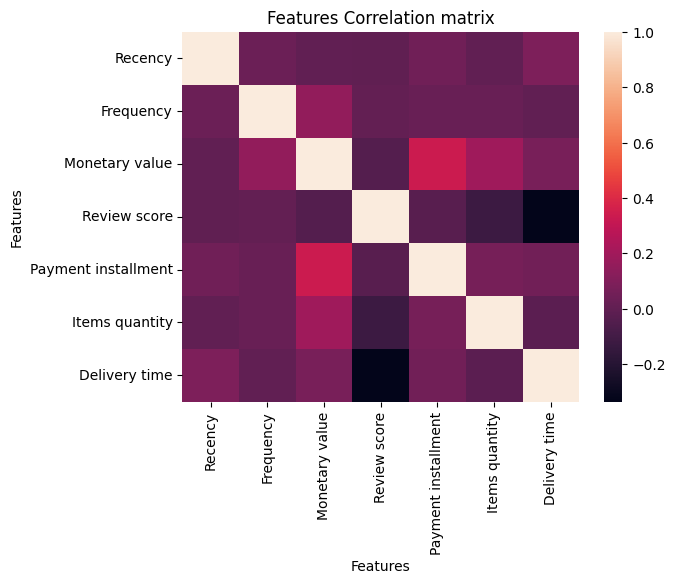

In [118]:
sns.heatmap(rfm_matrix.corr())

# Adding Labels and title
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Features Correlation matrix')

In [119]:
mask = (rfm_matrix['Frequency'] > 1)
rfm_matrix.loc[mask].shape[0] / rfm_matrix.shape[0] * 100

3.0717166365729978

3% of clients have ordered more than once (as said by Juan of the marketing team)

In [120]:
rfm_matrix.describe()

,Recency,Frequency,Monetary value,Review score,Payment installment,Items quantity,Delivery time
count,92489.000000,92489.000000,92489.000000,92489.000000,92489.000000,92489.000000,92489.000000
mean,236.856069,1.038815,164.660839,4.154195,2.895559,1.138439,12.044475
std,151.187148,0.249267,212.362177,1.279538,2.672248,0.521458,9.453189
min,0.000000,1.000000,9.590000,1.000000,0.000000,1.000000,0.000000
25%,114.000000,1.000000,63.060000,4.000000,1.000000,1.000000,6.000000
50%,218.000000,1.000000,107.800000,5.000000,2.000000,1.000000,10.000000
75%,346.000000,1.000000,182.830000,5.000000,4.000000,1.000000,15.000000
max,601.000000,15.000000,4655.910000,5.000000,24.000000,21.000000,208.000000


<Axes: xlabel='Frequency', ylabel='Count'>

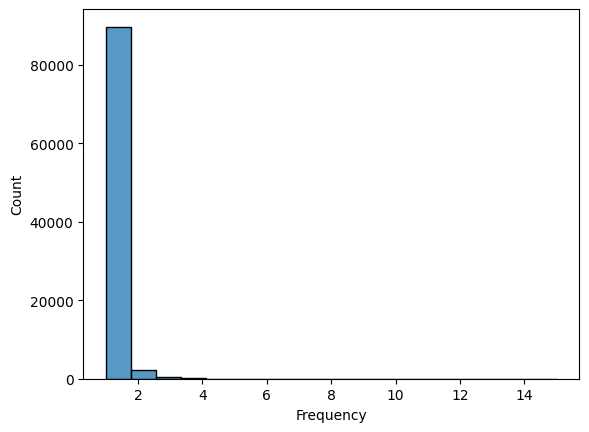

In [121]:
sns.histplot(rfm_matrix, x='Frequency')

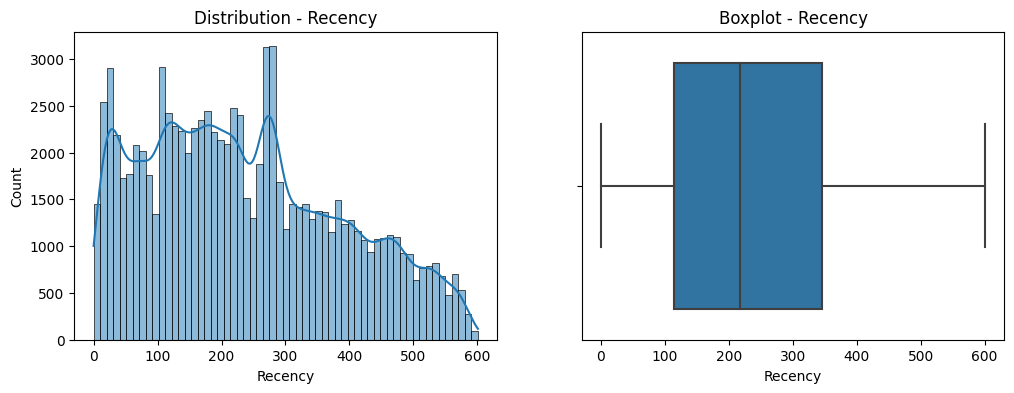

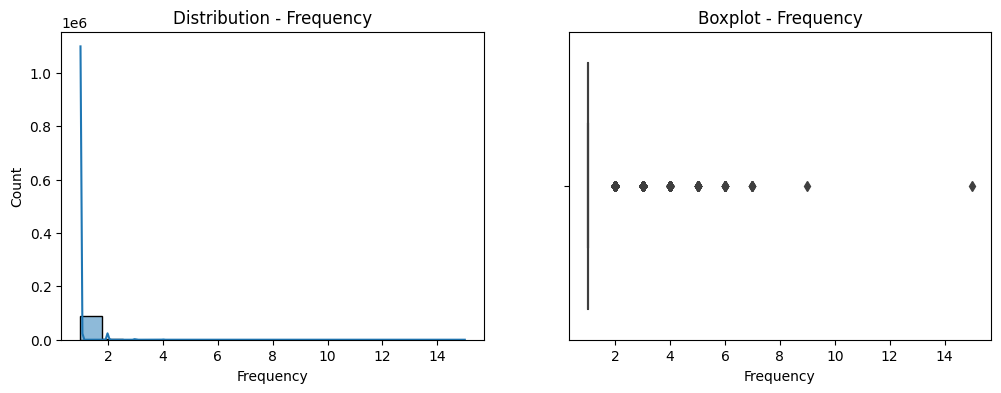

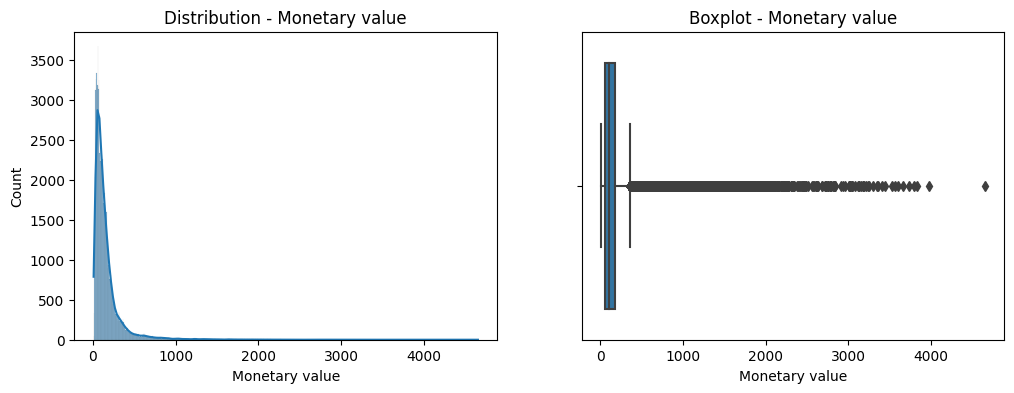

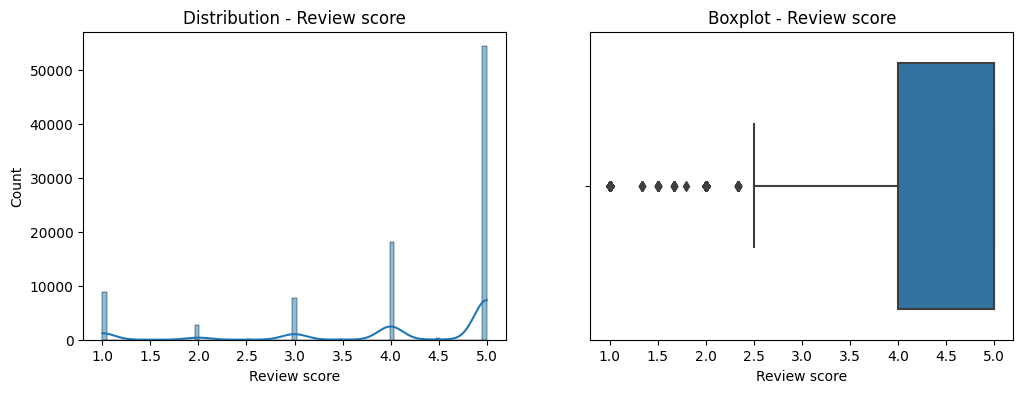

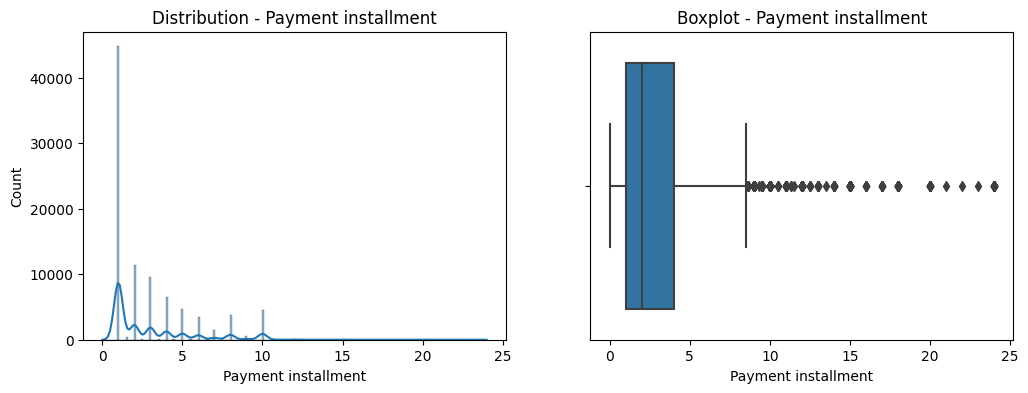

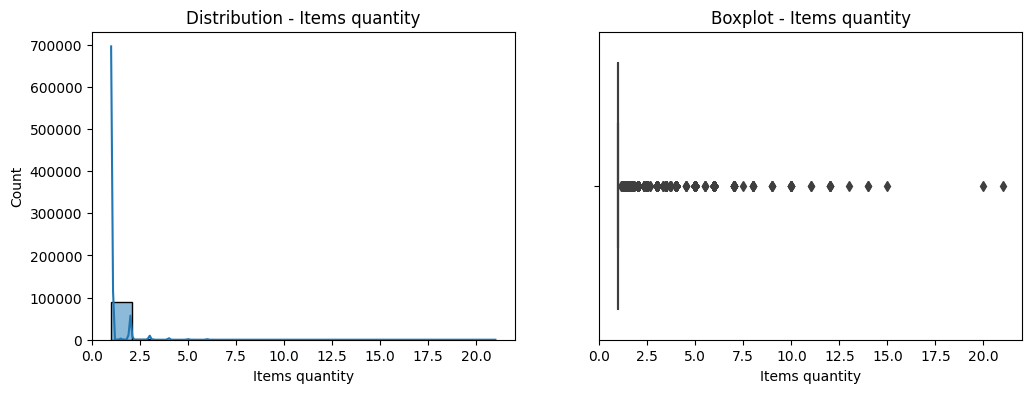

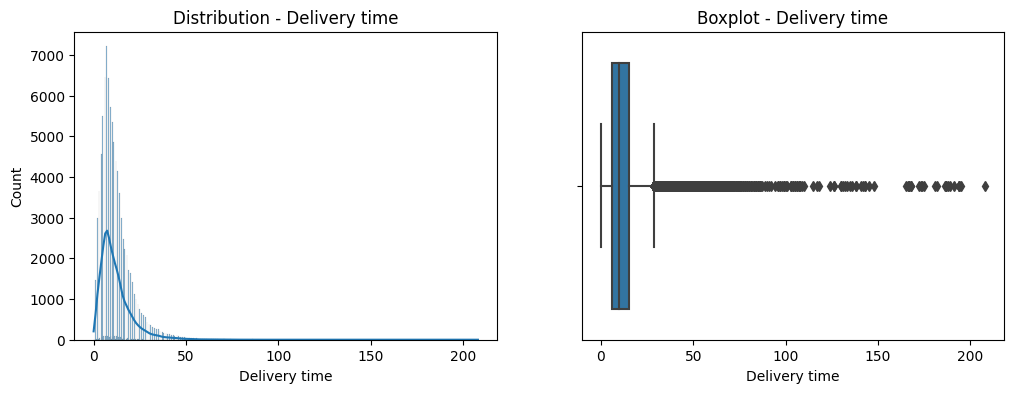

In [122]:
for column in rfm_matrix.iloc[:, 1:].columns:
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].title.set_text('Distribution - ' + str(column))
    sns.histplot(rfm_matrix, x=column, kde=True, ax=axs[0])

    axs[1].title.set_text('Boxplot - ' + str(column))
    sns.boxplot(rfm_matrix, x=column, ax=axs[1])

    plt.show()

## PCA

In [123]:
X = rfm_matrix.iloc[:, 1:].values
features = rfm_matrix.iloc[:, 1:].columns

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Creation of PCA object and fit
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X_scaled)

# Creation of a dataframe for Principal components
pca_df = pd.DataFrame(data=X_pca, columns=['PC1',
                                           'PC2',
                                           'PC3',
                                           'PC4',
                                           'PC5',
                                           'PC6',
                                           'PC7'])

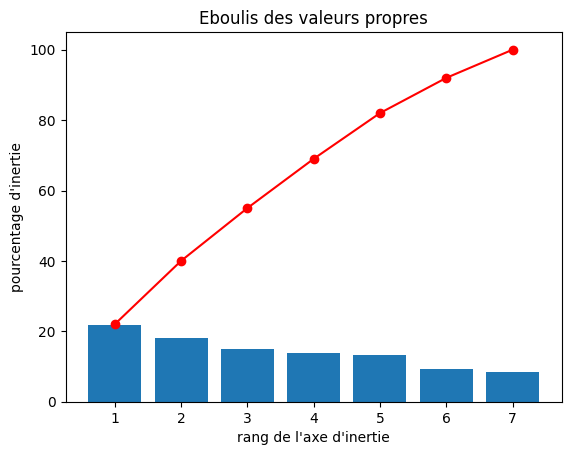

In [124]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree_cum = scree.cumsum().round()
x_list = range(1, 8)

plt.bar(x_list, scree)
plt.plot(x_list, scree_cum, c="red", marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [125]:
def correlation_graph(pca,
                      x_y,
                      features):
    """Print the correlation graph

    Positional arguments :
    -----------------------------------
    pca : sklearn.decomposition.PCA : our fitted PCA object
    x_y : list or tuple : x, y plans couple to print
    features : list or tuple : features list to represent
    """

    # Extract of x & y
    x, y = x_y

    fig, ax = plt.subplots(figsize=(10, 9))

    # For each components :
    for i in range(0, pca.components_.shape[1]):

        # The arrows
        ax.arrow(0, 0,
                 pca.components_[x, i],
                 pca.components_[y, i],
                 head_width=0.07,
                 head_length=0.07,
                 width=0.02)

        # The labels
        plt.text(pca.components_[x, i] + 0.05,
                 pca.components_[y, i] + 0.05,
                 features[i])

    # Display of vertical and horizontal lines
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Axes names, with percentage of inertia explained
    plt.xlabel('F{} ({}%)'.format(
        x+1, round(100*pca.explained_variance_ratio_[x], 1)))
    plt.ylabel('F{} ({}%)'.format(
        y+1, round(100*pca.explained_variance_ratio_[y], 1)))

    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # The circle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    plt.axis('equal')
    plt.show(block=False)

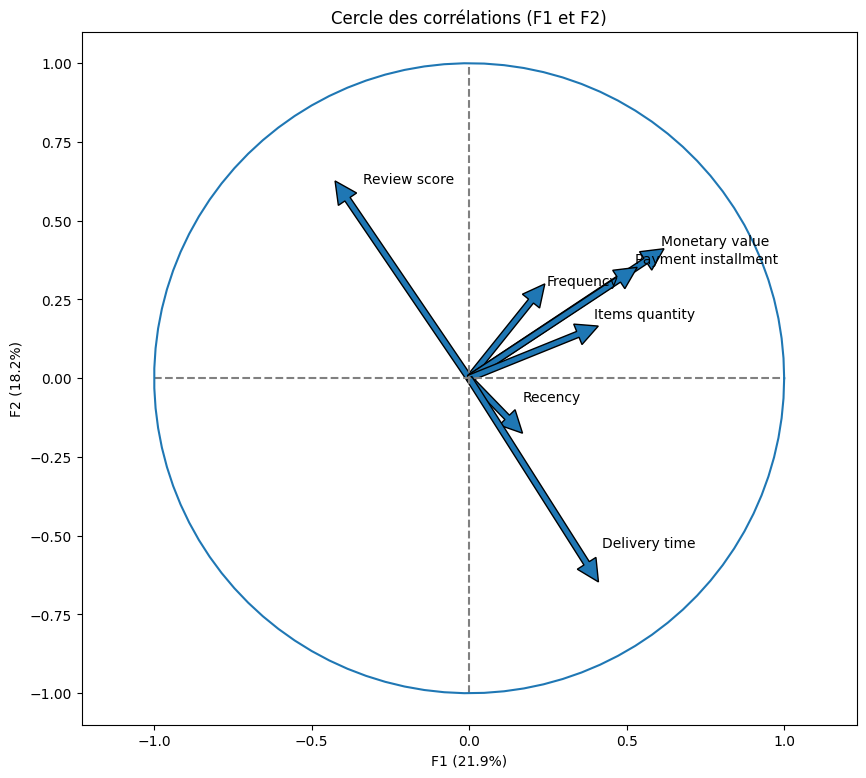

In [126]:
correlation_graph(pca, (0, 1), features)

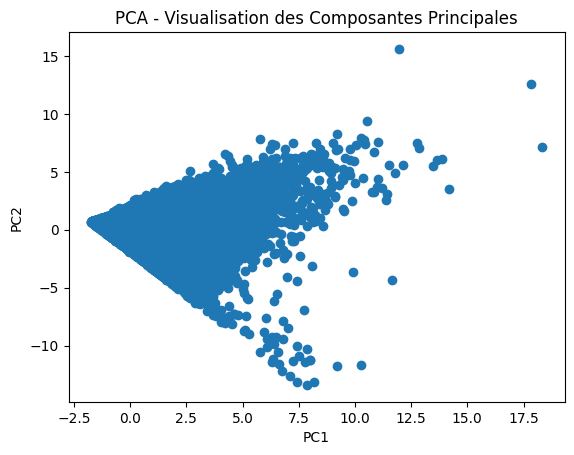

In [127]:
# Visualisation des composantes principales
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA - Visualisation des Composantes Principales')
plt.show()

## t-SNE

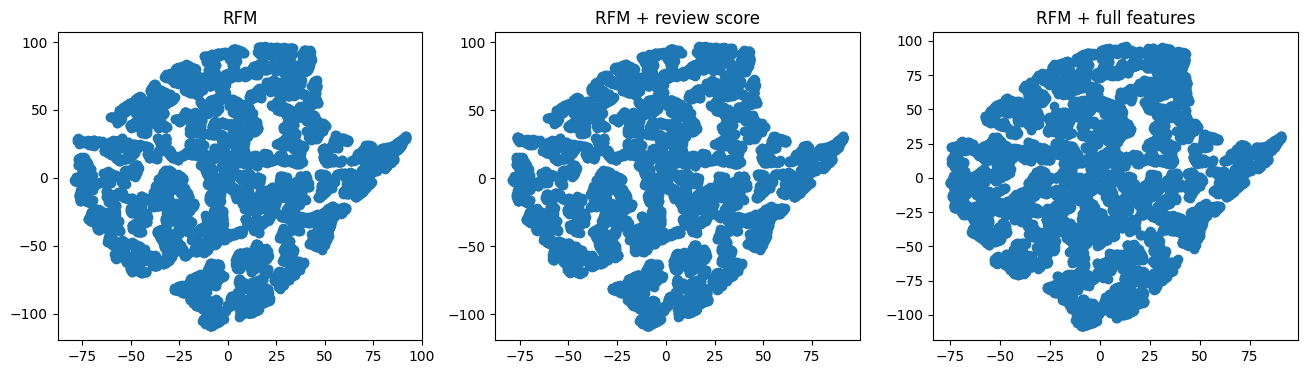

In [128]:
# Define the desired size of sample
sample_size = 10000

# Random sampling of the dataset
sample = rfm_matrix.sample(n=sample_size, random_state=42)
X_rfm = sample.iloc[:, 1:4].values
X_review = sample.iloc[:, 1:5].values
X_full = sample.iloc[:, 1:].values

# Mapping datas in a 2d t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_rfm = tsne.fit_transform(X_rfm)
tsne_review = tsne.fit_transform(X_review)
tsne_full = tsne.fit_transform(X_full)

# Creation of plot and subplots for each t-SNE
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

axs[0].scatter(tsne_rfm[:, 0], tsne_rfm[:, 1])
axs[0].title.set_text('RFM')
axs[1].scatter(tsne_review[:, 0], tsne_review[:, 1])
axs[1].title.set_text('RFM + review score')
axs[2].scatter(tsne_full[:, 0], tsne_full[:, 1])
axs[2].title.set_text('RFM + full features')
plt.show()

## t-SNE on PCA 

In [129]:
sampled_rows = np.random.choice(X_pca.shape[0], size=10000, replace=False)
X_pca_sample = X_pca[sampled_rows, :]
X_pca_sample.shape

(10000, 7)

Text(0.5, 1.0, 'RFM')

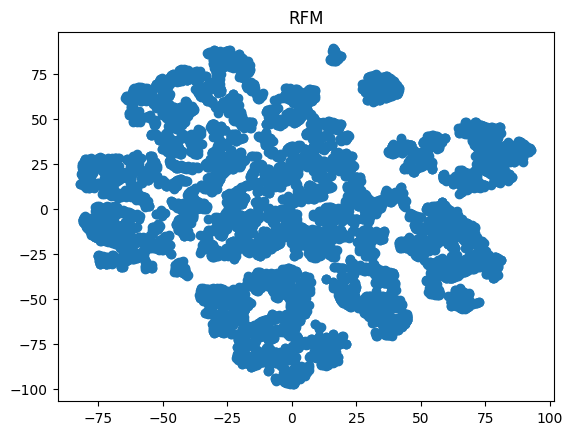

In [130]:
tsne_pca = tsne.fit_transform(X_pca_sample)

plt.scatter(tsne_pca[:, 0], tsne_pca[:, 1])
plt.title('RFM')

# Save

In [131]:
rfm_matrix.iloc[:, :4].to_csv('rfm_df.csv', index=False)

In [132]:
rfm_matrix.iloc[:, :5].to_csv('rfm_review.csv', index=False)

In [133]:
rfm_matrix.to_csv('full_df.csv', index=False)